# Infinite Data Stream

In [3]:
# Activate local environment, see `Project.toml`
import Pkg; Pkg.activate("."); Pkg.instantiate();

  Activating project at `~/.julia/dev/RxInfer/examples`


In [4]:
using RxInfer, Plots

┌ Info: Precompiling RxInfer [86711068-29c9-4ff7-b620-ae75d7495b3d]
└ @ Base loading.jl:1662


We assume that we don't know the shape of our signal in advance. So we try to fit a simple gaussian random walk with unknown observation noise:

In [5]:
mutable struct DataGenerationProcess
    previous :: Float64
    process_noise :: Float64
    observation_noise :: Float64
    history :: Vector{Float64}
    observations :: Vector{Float64}
end

function getnext!(process::DataGenerationProcess)
    process.previous = process.previous + 1.0
    next = 10sin(0.1 * process.previous)
    observation = next + rand(Normal(0.0, process.observation_noise))
    push!(process.history, next)
    push!(process.observations, observation)
    return observation
end

function gethistory(process::DataGenerationProcess)
    return process.history
end

function getobservations(process::DataGenerationProcess)
    return process.observations
end

getobservations (generic function with 1 method)

In [6]:
@model function kalman_filter()
    
    # Reactive inputs
    x_t_min_mean = datavar(Float64)
    x_t_min_var  = datavar(Float64)
    τ_shape = datavar(Float64)
    τ_rate  = datavar(Float64)

    τ ~ Gamma(shape = τ_shape, rate = τ_rate)
    
    x_t_min ~ Normal(mean = x_t_min_mean, variance = x_t_min_var)
    x_t     ~ Normal(mean = x_t_min, precision = 1.0)
    
    y = datavar(Float64)
    y ~ Normal(mean = x_t, precision = τ)
    
end


@constraints function filter_constraints()
    q(x_t, τ) = q(x_t)q(τ)
end

filter_constraints (generic function with 1 method)

In [159]:
# We force stop after n data points
n = 1000

1000

In [160]:
observational_noise_std = 1.0
observational_noise_var = abs2(observational_noise_std)
observational_noise_prec = inv(observational_noise_var)

process = DataGenerationProcess(0.0, 1.0, observational_noise_std, Float64[], Float64[])
# stream = timer(100, 100) |> map_to(process) |> map(Float64, getnext!) |> take(n)
stream = from(1:n) |> map_to(process) |> map(Float64, getnext!)

keystream = stream |> map(NamedTuple{(:y,), Tuple{Float64}}, (d) -> (y = d, ))

static = keep(eltype(keystream))
subscribe!(keystream, static)
static = collect(static);
y = map(d -> values(d)[1], static);

In [172]:
function testme(datastream)
    
    autoupdates = @autoupdates begin 
        x_t_min_mean, x_t_min_var = mean_var(q(x_t))
        τ_shape = shape(q(τ))
        τ_rate = rate(q(τ))
    end
    
    return rxinference(
        model = kalman_filter(),
        constraints = filter_constraints(),
        datastream = datastream,
        autoupdates = autoupdates,
        returnvars = (:x_t, ),
        keephistory = 10_000,
        historyvars = (x_t = KeepEach(), τ = KeepLast()),
        initmarginals = (
            x_t = NormalMeanVariance(0.0, 1e3),
            τ = GammaShapeRate(1.0, 1.0)
        ),
        iterations = 15,
        free_energy = true,
        autostart = true,
    )
end

testme (generic function with 1 method)

  0.244923 seconds (2.45 M allocations: 101.647 MiB, 8.00% gc time)
(mean((engine.history[:τ])[end]), observational_noise_prec) = (0.8242286987395373, 1.0)


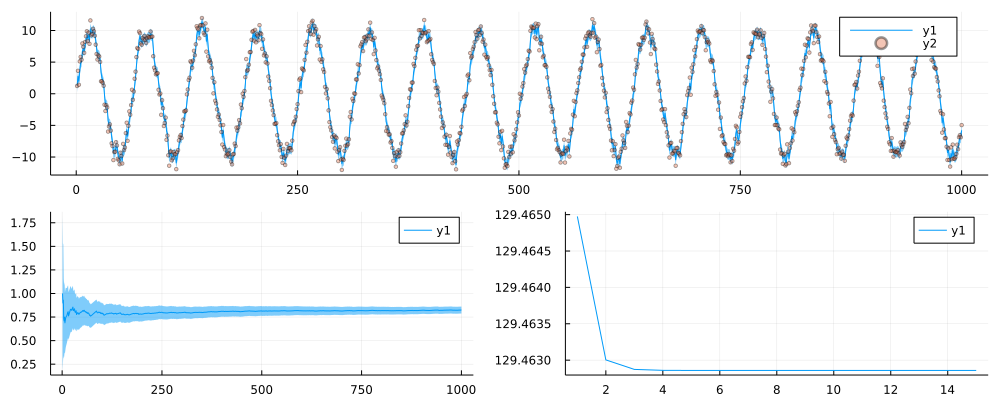

In [174]:
@time engine = testme(from(static))

qxt = last.(engine.history[:x_t])
qτ = engine.history[:τ]
# y = engine.history[:y]

@show mean(engine.history[:τ][end]), observational_noise_prec

p1 = plot(mean.(qxt), ribbon = std.(qxt))
p1 = scatter!(y, ms = 2, alpha = 0.4)
p2 = plot(mean.(qτ), ribbon = std.(qτ))
p3 = plot(getvalues(engine.fe_actor))

plot(p1, p2, p3, layout = @layout([ a; b c ]), size = (1000, 400))

In [170]:
using BenchmarkTools

In [171]:
@benchmark testme(from($static))

BenchmarkTools.Trial: 19 samples with 1 evaluation.
 Range (min … max):  222.488 ms … 397.169 ms  ┊ GC (min … max): 0.00% … 8.97%
 Time  (median):     272.026 ms               ┊ GC (median):    6.80%
 Time  (mean ± σ):   277.132 ms ±  39.026 ms  ┊ GC (mean ± σ):  6.51% ± 2.43%

  ▁   ▁  ▁▁▁  █▁ ▁ █▁ ▁▁   ▁   ▁▁   ▁                         ▁  
  █▁▁▁█▁▁███▁▁██▁█▁██▁██▁▁▁█▁▁▁██▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  222 ms           Histogram: frequency by time          397 ms <

 Memory estimate: 101.65 MiB, allocs estimate: 2450329.

In [124]:
plot_callback = (posteriors) -> begin
    IJulia.clear_output(true)

    p = plot(mean.(posteriors), ribbon = var.(posteriors), label = "Estimation")
    p = plot!(gethistory(process), label = "Real states")    
    p = scatter!(getobservations(process), ms = 2, label = "Observations")
    p = plot(p, size = (1000, 400), legend = :bottomright)
        
    display(p)
end

#127 (generic function with 1 method)